# Least cost paths <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** This notebook loads data from an external raster file (`canberra_dem_250m.tif`) from the `Supplementary_data` folder of this repository


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import numpy as np
from skimage.graph import route_through_array
import matplotlib.pyplot as plt
import xarray as xr

In [59]:
# image_da = xr.DataArray(image, coords=(-np.arange(3000, 3500), np.arange(1000, 1500)), dims=['y', 'x'])

# Synthetic example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


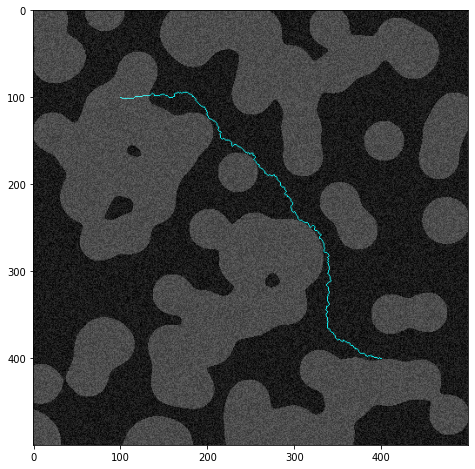

In [2]:
from skimage import data
from numpy.random import rand
image = data.binary_blobs(length=500) 
image = (image.astype(float)/(image.max()) + rand(*image.shape)) / 2.0

# Find the path with lowest cost
indices, weight = route_through_array(image, (100, 100), (-100, -100))
indices = np.stack(indices, axis=-1)
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1

plt.figure(figsize=(8,8))
plt.imshow(np.stack([image * 0.4, path + image * 0.4, path + image * 0.4], axis=2))

# Datacube example

In [5]:
import datacube
dc = datacube.Datacube(app="Reprojecting_data")

import sys
sys.path.append("../Tools")
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices

In [402]:
# Create a reusable query
query = {
    'x': ( 152.30, 152.40),
    'y': (-24.70, -24.80),
    'time': ('1998-06', '1999-06'),
    'measurements': [
#         'nbart_blue', 
        'nbart_green', 
#         'nbart_red', 
#         'nbart_nir', 
        'nbart_swir_1',
#         'nbart_swir_2'
    ],
    'output_crs': 'EPSG:3577',
    'resampling': 'average',
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {}
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3'], 
              min_gooddata=0.90, 
              mask_pixel_quality=False, 
              **query)

/home/jovyan/Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
Counting good quality pixels for each time step
Filtering to 11 out of 19 time steps with at least 90.0% good quality pixels
Returning 11 time steps as a dask array


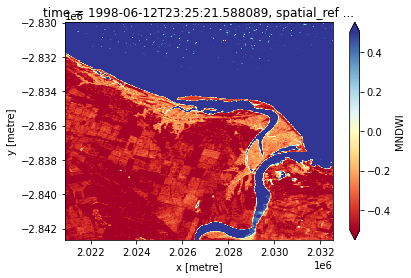

In [403]:
# Calculate NDVI using the formula above
# da = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)
da = calculate_indices(ds, index='MNDWI', collection='ga_ls_3').MNDWI

# Plot the results for one time step to see what they look like:
da = da.isel(time=0)
da.plot(vmin=-0.5, vmax=0.5, cmap='RdYlBu')

In [12]:
coords_start_crs = 2028291.63892949, -2834524.95323676
coords_end_crs = 2029000.99446205, -2834623.37507558
coords_start = ~da.geobox.transform * coords_start_crs
coords_end = ~da.geobox.transform * coords_end_crs

In [13]:
# Find the path with lowest cost
image = ((da.where(da < 0.5, 100) + 1) / 2)
# image = (1 - (da.where((da > -0.5) & (da < 0.5))  + 1) / 2) * 0.5
# image = (-np.log2(((da + 1) / 2)))
indices, weight = route_through_array(image.values, [int(x) for x in coords_start[::-1]], [int(x) for x in coords_end[::-1]])
indices = np.stack(indices, axis=-1)
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1


<AxesSubplot:title={'center':'time = 1998-06-12T23:25:21.588089, spatial_ref ...'}, xlabel='x [metre]', ylabel='y [metre]'>

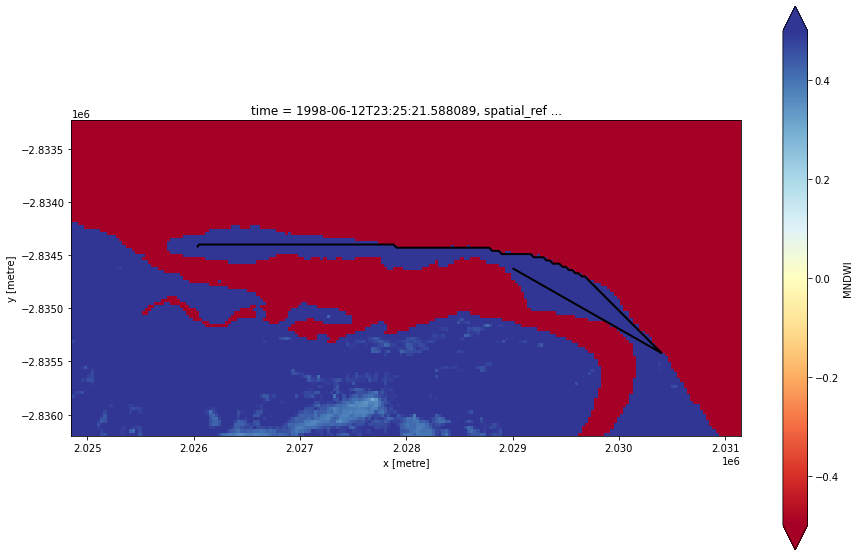

In [330]:
from shapely.geometry import Point, LineString
import geopandas as gpd

# Reproject indices
indices_crs = [da.geobox.transform * i for i in indices.T[:, (1, 0)]]
indices_crs[0] = coords_start_crs
indices_crs[-1] = coords_end_crs

geom = LineString(indices_crs)
image.plot(size=10, cmap = 'RdYlBu', vmax=0.5, vmin=-0.5)
path_gs = gpd.GeoSeries(geom)
path_gs.plot(ax=plt.gca(), color='black', linewidth=2)

# plt.figure()
# image.plot.hist()

In [15]:
print(path_gs.geometry.length / weight) 
print((path_gs.geometry.length / weight) > 50)

0    89.328728
dtype: float64
0    True
dtype: bool


## Test of cost distance method

In [525]:
from dea_tools.spatial import xr_rasterize
from skimage import graph

def lcp_distance(point, shorelines, cs, cell_size=30, simplify=30):

    # From the cost-surface create a 'landscape graph' object which can be
    # analysed using least-cost modelling
    lg = graph.MCP_Geometric(cs, sampling=(cell_size, cell_size))

    # Convert input point to pixel-based indices
    coords_start_crs = list(point.coords)[0]
    coords_start = ~cs.geobox.transform * coords_start_crs

    # Rearrange starting coordinates and convert to integers
    starts = [[int(x) for x in coords_start[::-1]]]
    
    ######################
    
    out_distances = []
    
    for i, row in shorelines.iterrows():
        
        try:
    
            shoreline = shorelines.loc[[i]]

            # Obtain ending points via rasterising shoreline features
            end_array = xr_rasterize(shoreline, cs).values
            ends = list(zip(*np.nonzero(end_array)))

            # Calculate the least-cost distance from the start cell to all other cells
            lcd, trace = lg.find_costs(starts=starts, 
                                       ends=ends, 
                                       find_all_ends=False)

            # Determine location of nearest end point based on intersection between
            # least cost distance array and end point array
            end_y, end_x = np.nonzero((end_array.astype(bool) & np.isfinite(lcd)))

            # Obtain indices of least cost path
            traceback = lg.traceback((end_y, end_x))

            # Reproject indices back to original CRS coordinates
            lcp_coords = [cs.geobox.transform * i for i in 
                          np.array(traceback)[:, (1, 0)]]

            # To obtain subpixel distances, replace first pixel index-based 
            # coordinate with original starting point coordinate
            indices_crs[0] = coords_start_crs

            # Similarly, replace final pixel-based index with the nearest
            # location between this coordinate and our original shoreline vector    
            indices_crs[-1] = list(nearest_points(Point(indices_crs[-1]), 
                                                  shoreline.geometry.iloc[0])[1].coords)[0]

            # Convert to linestring 
            geom = LineString(lcp_coords)

            # Optionally simplify to remove pixel boundary artefacts
            if simplify:   
                geom = geom.simplify(simplify, 
                                     preserve_topology=False)

            # Convert to geodataframe and export
            lcp_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geom), 
                                       crs=ds.crs)

            out_distances.append(geom.length)
        
        except:
            out_distances.append(np.nan)
            
    import pandas as pd
    return pd.Series(out_distances)
            

#         # Plot
#         cs.plot(size=10, cmap='Greys', alpha=0.2)
#         lcp_gdf.plot(ax=plt.gca(), color='black', linewidth=2)
#         shoreline.plot(ax=plt.gca(), linewidth=5, color='green')
#         plt.show()






In [526]:
# Input point
point = Point(2026031.7593087438, -2834426.2773086852)

# Input shoreline
shorelines = gpd.read_file('example_shoreline.geojson').to_crs(ds.crs)

# Input cost surface
x, y = list(point.coords)[0]
da_window = da.sel(y=slice(y+2000, y-2000), x=slice(x-2000, x+2000))
cs = xr.where(da_window < 0.5, 1, -1)

In [527]:
# Compute LCP distance
lcp_distance(point, shorelines, cs, cell_size=30, simplify=30)

0    1147.279221
1    1374.852814
2    1447.279221
3    1747.279221
4    1832.132034
5            NaN
dtype: float64

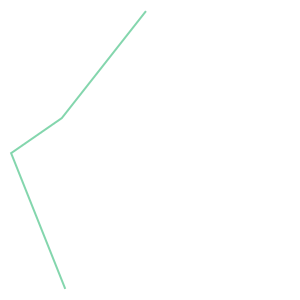

In [490]:
shoreline.geometry

In [530]:
%load_ext line_profiler
%lprun -f lcp_distance lcp_distance(point, shorelines, cs, cell_size=30)



The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.576762 s

Could not find file /tmp/ipykernel_739/262610481.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           
     5                                           
     6                                           
     7                                           
     8         1     120013.0 120013.0     20.8  
     9                                           
    10                                           
    11         1        173.0    173.0      0.0  
    12         1       1690.0   1690.0      0.3  
    13                                           
    14                                           
    15         1          9.0      9.0      0.0  
    16                                           
    17                                         

<AxesSubplot:title={'center':'time = 1998-06-12T23:25:21.588089, spatial_ref ...'}, xlabel='x [metre]', ylabel='y [metre]'>

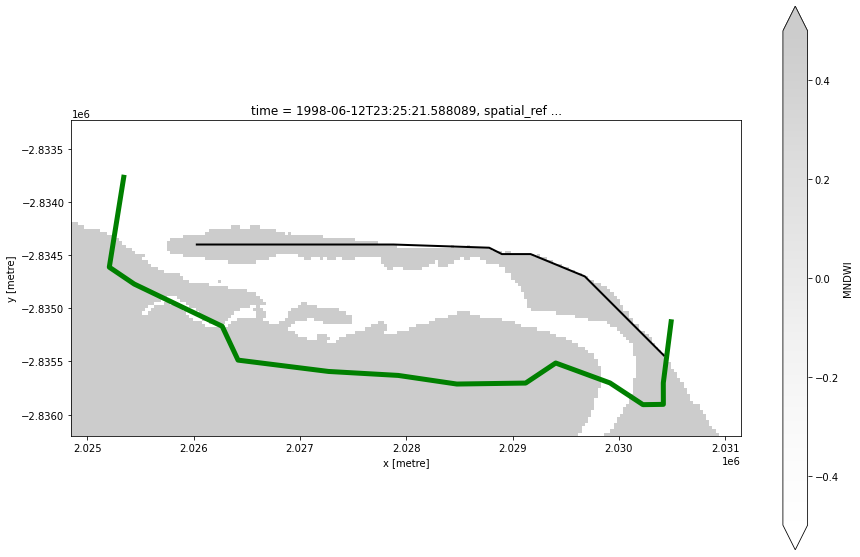

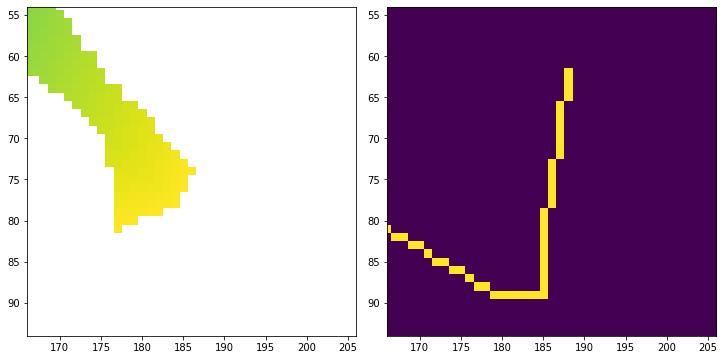

In [322]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
fig.tight_layout(pad=0)
axes[0].imshow(lcd)
axes[1].imshow(end_array)

for ax in axes:
        ax.set_ylim(end_y + 20, end_y - 20)
        ax.set_xlim(end_x - 20, end_x + 20)

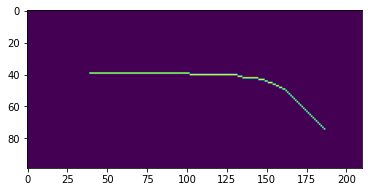

In [341]:
# traceback = lg.traceback((end_y, end_x))
indices = np.array(traceback).T
path = np.zeros_like(lcd)
path[indices[0], indices[1]] = 1
plt.imshow(path)

<AxesSubplot:title={'center':'time = 1998-06-12T23:25:21.588089, spatial_ref ...'}, xlabel='x [metre]', ylabel='y [metre]'>

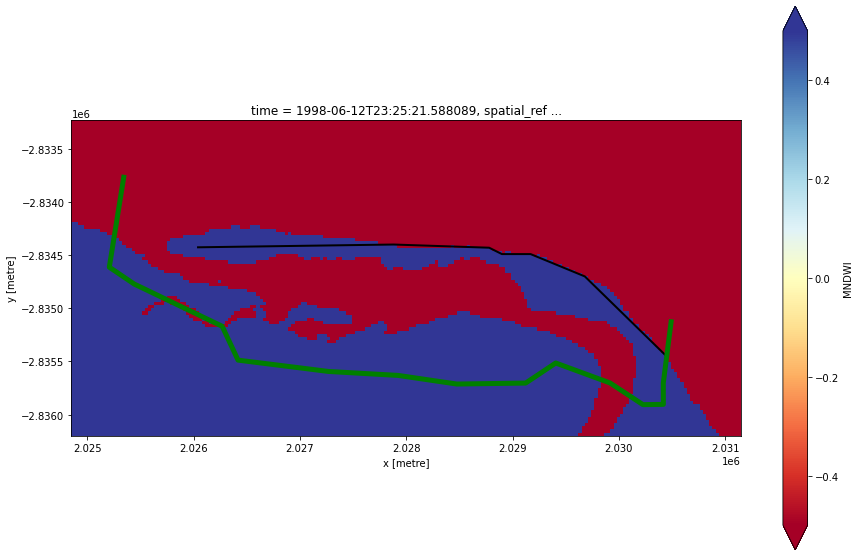

In [302]:
from shapely.geometry import Point, LineString
import geopandas as gpd
from shapely.ops import nearest_points

# Reproject indices
indices_crs = [da.geobox.transform * i for i in indices.T[:, (1, 0)]]
indices_crs[0] = coords_start_crs
indices_crs[-1] = list(nearest_points(Point(indices_crs[-1]), 
                                      shoreline.geometry[0])[1].coords)[0]

geom = LineString(indices_crs).simplify(30, preserve_topology=False)
cs.plot(size=10, cmap = 'RdYlBu', vmax=0.5, vmin=-0.5)
path_gs = gpd.GeoSeries(geom)
path_gs.plot(ax=plt.gca(), color='black', linewidth=2)
shoreline.plot(ax=plt.gca(), linewidth=5, color='green')

In [281]:
least_cost_path = gpd.GeoDataFrame(geometry=path_gs, crs=ds.crs)
least_cost_path.to_file('test_least_cost.geojson')

In [282]:
least_cost_path.length

0    4781.655174
dtype: float64

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)